In [1]:

import nltk
import re
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt
import os
import string
import pyLDAvis.gensim
from bs4 import BeautifulSoup
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary

nltk.download('stopwords')
from nltk.corpus import stopwords

pyLDAvis.enable_notebook()

random_seed = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cs/grad/opumni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import multiprocessing
num_cores = multiprocessing.cpu_count()

/home/cs/grad/opumni/Research/StudyOnBlockchainApps/.conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def preprocess_text(text):
    if text:
        # Remove HTML tags using BeautifulSoup
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text(separator=" ")  # Extract text and replace tags with a space   
        # Remove email addresses
        text = re.sub(r'\S*@\S*\s?', '', text)
        # Replace multiple whitespace characters with a single space
        text = re.sub(r'\s+', ' ', text)
        # Remove single and double quotes
        text = text.replace("'", "").replace('"', '')
        # Remove punctuation
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        # Strip leading and trailing whitespace
        text = text.strip()
    return text

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def compute_coherence_values(dictionary, corpus, texts, mallet_path, start=5, limit=70, step=5, iteration = 1000):
    coherence_values = []
    models = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.wrappers.LdaMallet(
            mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary,
            iterations=iteration, alpha=50/num_topics, random_seed=50, workers=num_cores)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return models, coherence_values

def format_topics_sentences(ldamodel, corpus, texts, df):
    sent_topics_df = []
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: x[1], reverse=True)
        dominant_topic = row[0]
        sent_topics_df.append([
            int(dominant_topic[0]),
            round(dominant_topic[1], 4),
            ", ".join([word for word, prop in ldamodel.show_topic(dominant_topic[0])]),
            df.iloc[i]["Repository"],
            df.iloc[i]["IssueId"],
            df.iloc[i]["Title"],
            df.iloc[i]["Body"],
            df.iloc[i]["State"],
            df.iloc[i]["Label"],
            df.iloc[i]["CreatedAt"],
            df.iloc[i]["ClosedAt"],
            texts[i]  # Add combined text
        ])
    df_all_topics = pd.DataFrame(sent_topics_df, columns=[
        'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 
        'Repository', 'IssueId', 'Title', 'Body','State','Label','CreatedAt','ClosedAt','combinedText'])
    for topic_id in df_all_topics['Dominant_Topic'].unique():
        topic_df = df_all_topics[df_all_topics['Dominant_Topic'] == topic_id]
        topic_df.to_csv(f"./Topics/topic_{topic_id}_associated_posts.csv", index=False)
    return df_all_topics

/home/cs/grad/opumni/Research/StudyOnBlockchainApps/.conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
mallet_path = '/home/cs/grad/opumni/Research/Mockito/MockingResearch2024/Mallet-202108/bin/mallet'

/home/cs/grad/opumni/Research/StudyOnBlockchainApps/.conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
df

/home/cs/grad/opumni/Research/StudyOnBlockchainApps/.conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Repository,IssueId,Title,Body,State,Label,CreatedAt,ClosedAt,combinedText
5,opexdev/core,511,Config connection pool for api webclient,NaN,closed,bug,2025-03-01 10:00:14+00:00,2025-03-01 10:06:12+00:00,config connection pool for api webclient
37,opexdev/core,476,Remove log() which (probably) caused memory leak,NaN,closed,bug,2024-11-12 13:26:42+00:00,2024-11-13 10:01:43+00:00,remove log which probably caused memory leak
41,opexdev/core,472,Fix enum mismatch for WalletType in bc-gateway,NaN,closed,bug,2024-10-05 14:13:01+00:00,2024-10-05 14:20:19+00:00,fix enum mismatch for wallettype in bcgateway
44,opexdev/core,469,Add docker compose instead of docker-compose i...,NaN,closed,bug,2024-09-18 14:47:28+00:00,2024-09-18 14:54:21+00:00,add docker compose instead of dockercompose in...
45,opexdev/core,468,Fix quote asset not considered in total assets,NaN,closed,bug,2024-09-18 13:11:48+00:00,2024-09-18 14:36:32+00:00,fix quote asset not considered in total assets
...,...,...,...,...,...,...,...,...,...
510717,NeoNextClub/neoline,23,Event BLOCK_HEIGHT_CHANGED provides non-contin...,I tried:\r\n\r\n```javascript\r\nconst fn = (d...,closed,bug,2021-03-30 23:14:22+00:00,2021-05-06 13:02:10+00:00,event blockheightchanged provides noncontinuou...
510721,NeoNextClub/neoline,19,deploy() does not work,## Steps to reproduce:\r\nExecute:\r\n```js\r\...,closed,bug,2019-09-20 12:29:26+00:00,2019-12-31 06:38:20+00:00,deploy does not work steps to reproduce execut...
510727,NeoNextClub/neoline,13,Two invokeRead method invocation will mix the ...,```\r\nconst a = await neoline.invokeRead({\r\...,closed,bug,2019-06-21 09:13:13+00:00,2019-09-12 03:06:59+00:00,two invokeread method invocation will mix the ...
510735,NeoNextClub/neoline,5,getAccount Alias returns undefined,getAccount alias seems like its not working an...,closed,bug,2019-05-06 04:08:18+00:00,2019-06-11 06:30:04+00:00,getaccount alias returns undefined getaccount ...


/home/cs/grad/opumni/Research/StudyOnBlockchainApps/.conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


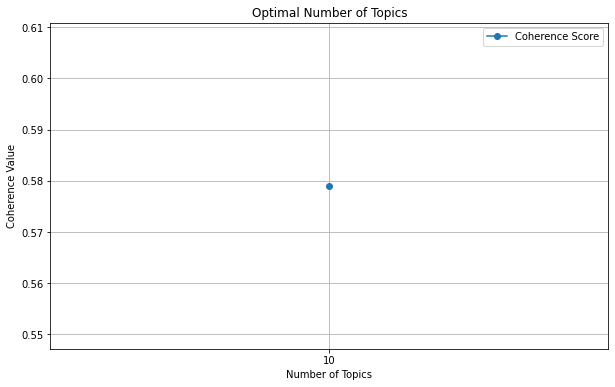

Optimal number of topics: 10
Processing complete. Files saved.


In [15]:
for i in [500]:
    df = pd.read_csv("./Data/AllIssues.csv")
    #df["Label"] = df["Label"].fillna("")
    #df = df[df["Label"].str.contains("bug")]
    data = df['combinedText'].tolist()

    data_words = list(sent_to_words(data))
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    data_lemmatized = lemmatization([bigram_mod[doc] for doc in data_words])
    id2word = corpora.Dictionary(data_lemmatized)
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    
    start = 10
    limit = 10
    step = 10 
    models, coherence_values = compute_coherence_values(id2word, corpus, data_lemmatized, mallet_path,start=start, limit=limit,step=step, iteration = i)

    # Plot coherence values
    x = range(start, limit+step, step)
    plt.figure(figsize=(10, 6))
    plt.plot(x, coherence_values, marker='o', label='Coherence Score')
    plt.xticks(x)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Value")
    plt.title("Optimal Number of Topics")
    plt.legend()
    plt.grid()
    plt.savefig("./Topics/coherence_vs_topics.png")
    plt.show()

    best_index = np.argmax(coherence_values)
    best_model = models[best_index]
    optimal_k = range(start, limit+step, step)[best_index]
    print(f"Optimal number of topics: {optimal_k}")

    # Adjust the number of top words for each topic to 30
    topics = best_model.show_topics(num_topics=-1, num_words=30, formatted=False)
    # Create a DataFrame for the top words
    top_words_df = pd.DataFrame(
        [{"Topic": topic[0], "Word": word, "Probability": prob}
        for topic in topics for word, prob in topic[1]]
    )
    top_words_df.to_csv("./Topics/topics_keywords.csv", index=False)


    df_topics = format_topics_sentences(best_model, corpus, data, df)
    df_topics.to_csv("./Topics/topics_associated_posts.csv", index=False)

    print("Processing complete. Files saved.")
    os.rename("Topics",f"Topics-{i}")
    os.mkdir("Topics")